# evaluation enformer 5

we can show some more examples of plots and also see some basic ISM

In [1]:
#let's make sure the architecture looks good
ckpt_path = '/data/leslie/sarthak/caduceus/outputs/2024-09-19/15-10-56-043853/checkpoints/44-val_loss=0.58429.ckpt'
# we have lots of model outputs, now let's test it to see what works
import torch
import sys
sys.path.append('/data/leslie/sarthak/caduceus')
import evals.evals_utils_enformer as e
#now let's load the model anad we can plot some things
import numpy as np
split = 'test'

labels = np.load(f'/data/leslie/sarthak/data/enformer/data/{split}_label.npy')

evals = e.Evals(ckpt_path)

Using kmer genome with length 6
4675


In [2]:
#now we want to do ISM, which requires knowing which nucleotide it is, and changing all the corresponding values
#first let's find an example to do ISM on
import matplotlib.pyplot as plt

file_path = '/data/leslie/sarthak/data/enformer/data/human/targets.txt'

# Initialize an empty dictionary
targets_dict = {}

# Open and read the file
with open(file_path, 'r') as file:
    for line in file:
        #skip the first line
        if line.startswith('index'):
            continue
        # Split the line into columns
        columns = line.strip().split('\t')
        
        # The first column (index 0) is the key
        key = int(columns[0])
        
        # The last column is the description
        description = columns[-1]
        
        # Add to the dictionary
        targets_dict[key] = description

def plot_track(evals, enf_out, idx, track=121):
    '''
    given an index, plots one track and compares it to the real results
    '''
    #now plot the track
    seq, label = evals.dataset[idx]
    # data = data.cpu().numpy()
    x = evals(data = seq).cpu().squeeze().numpy()
    fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 12), sharex=True)

    ax1.plot(x[:, track], label='Predicted Coverage', color='b')
    ax1.set_title('Predicted Coverage')
    ax1.legend()

    ax2.plot(enf_out[idx,:,track], label='Enformer Output', color='g')
    ax2.set_title('Enformer Output')
    ax2.legend()

    ax3.plot(label[:, track], label='Actual Coverage', color='r')
    ax3.set_title('Actual Coverage')
    ax3.legend()

    ax3.set_xlabel('Position')
    fig.suptitle(f'Model Coverage Comparison, Track {targets_dict[track]}, sample {idx}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return fig, (ax1, ax2, ax3)

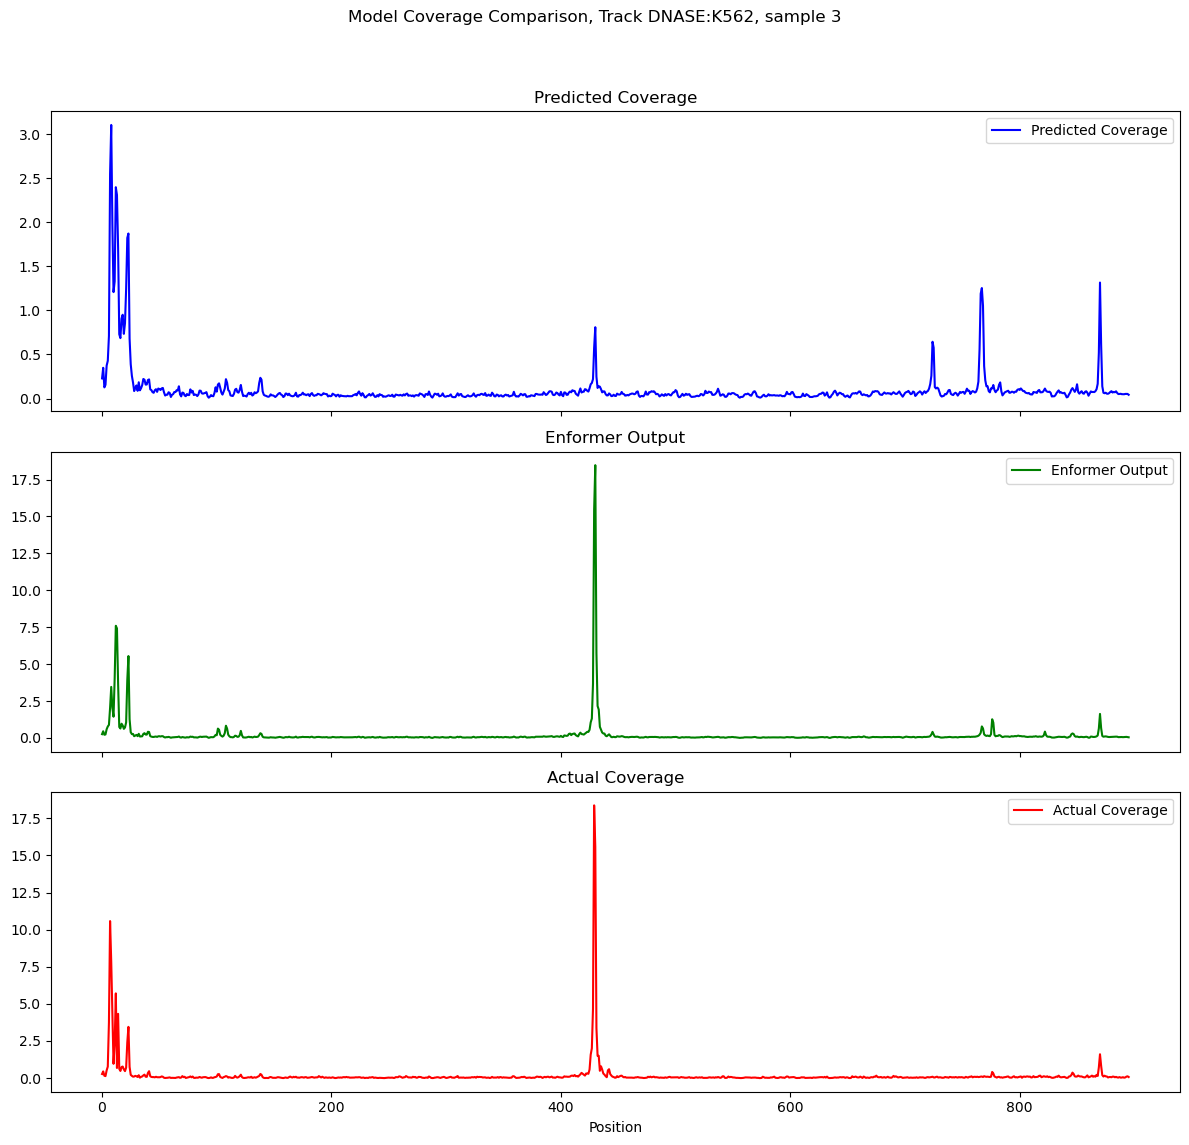

(<Figure size 1200x1200 with 3 Axes>,
 (<Axes: title={'center': 'Predicted Coverage'}>,
  <Axes: title={'center': 'Enformer Output'}>,
  <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>))

In [3]:
enformer = np.load('/data/leslie/sarthak/data/enformer/data/model_out/enformer.npy')
plot_track(evals, enformer, 3, track=121)

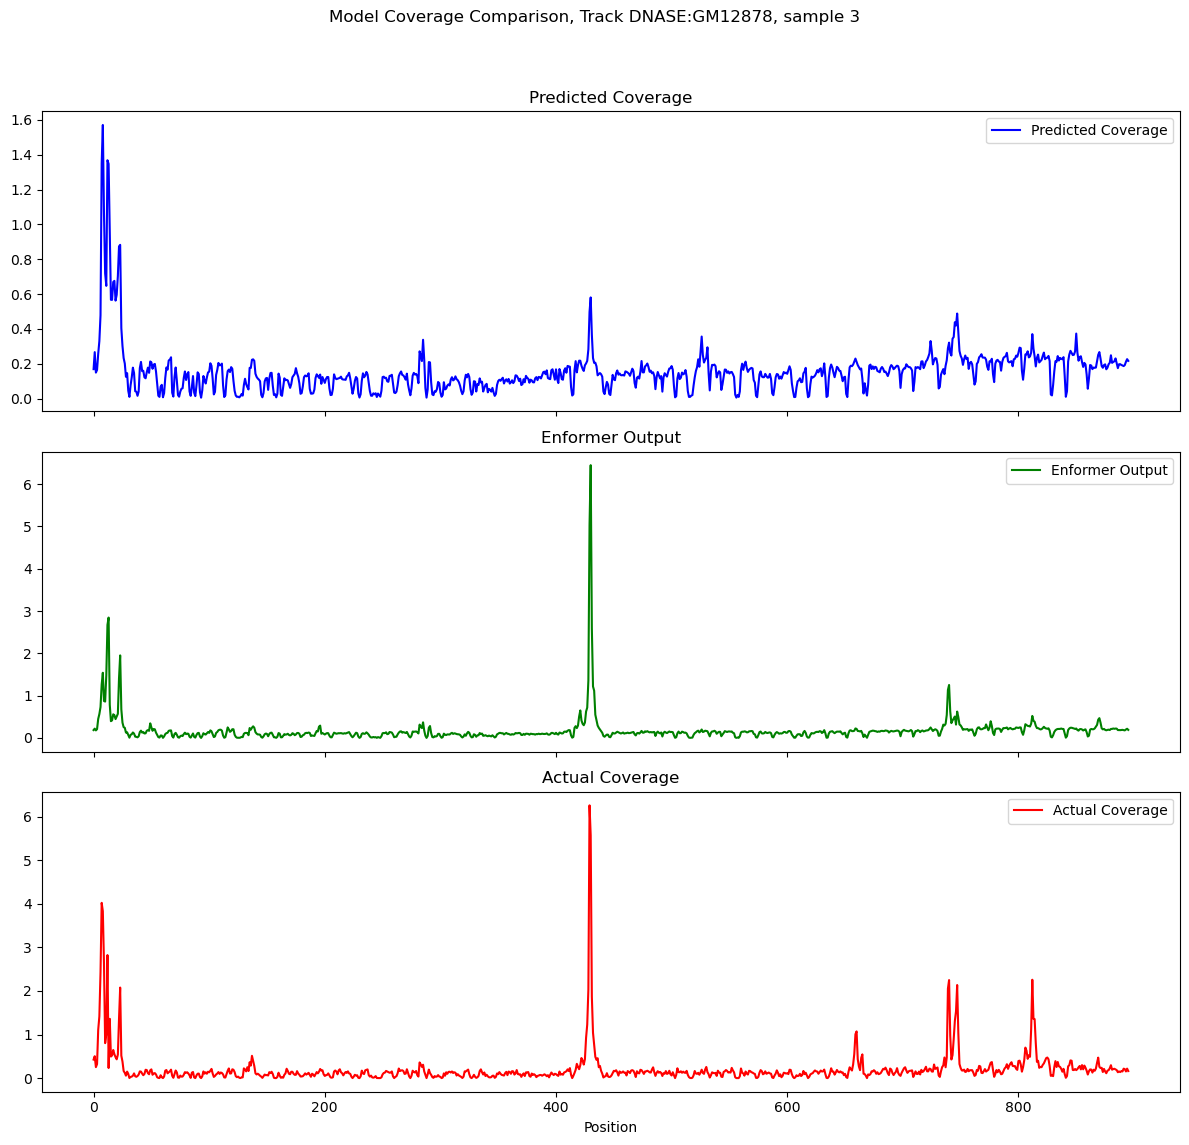

(<Figure size 1200x1200 with 3 Axes>,
 (<Axes: title={'center': 'Predicted Coverage'}>,
  <Axes: title={'center': 'Enformer Output'}>,
  <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>))

In [4]:
plot_track(evals, enformer, 3, track=12)

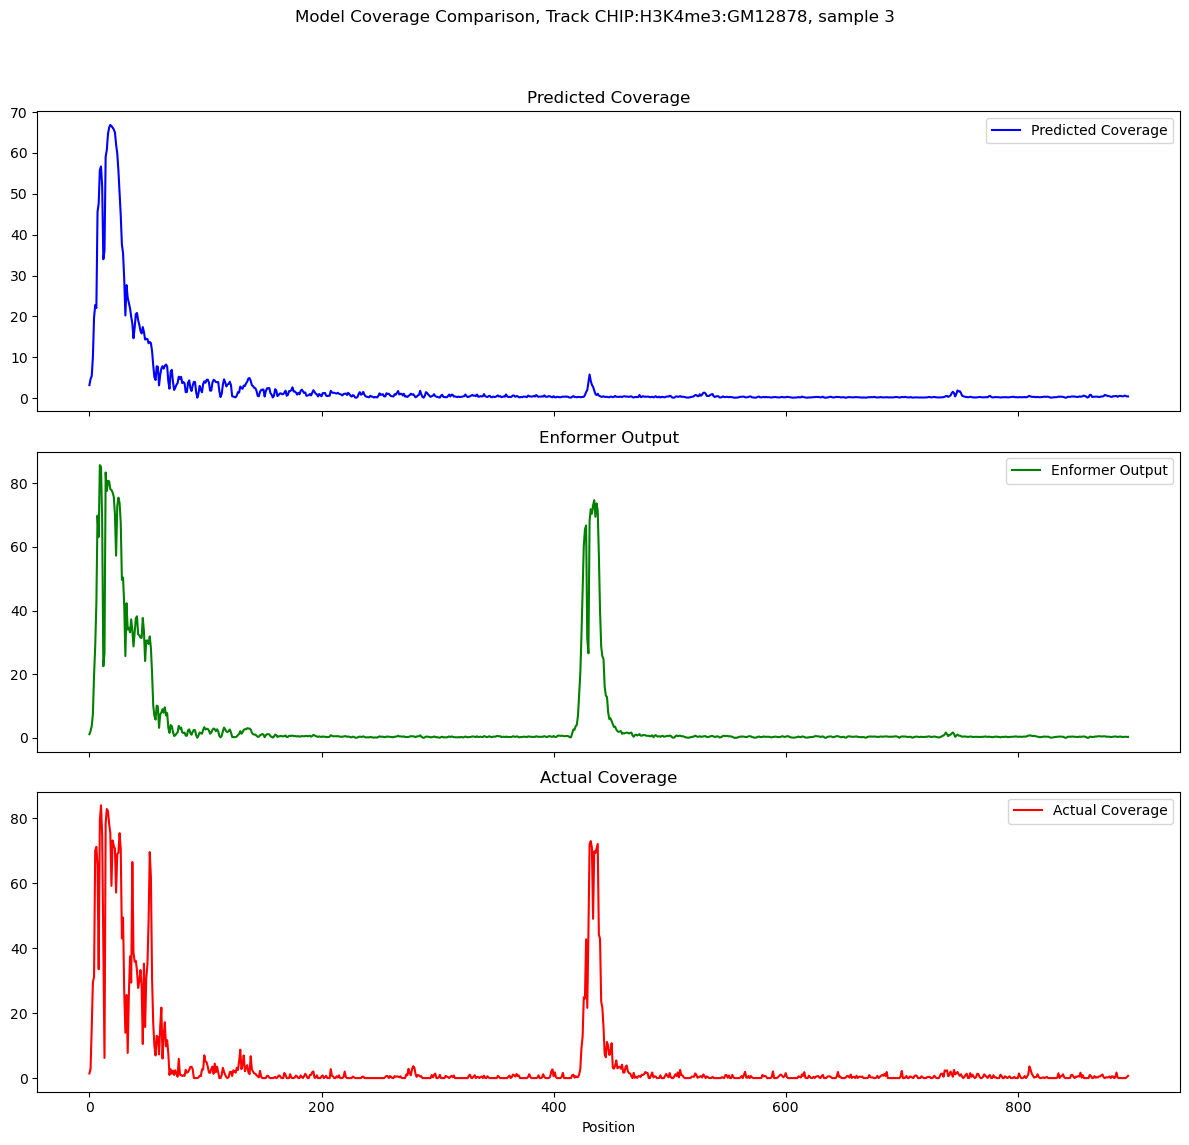

(<Figure size 1200x1200 with 3 Axes>,
 (<Axes: title={'center': 'Predicted Coverage'}>,
  <Axes: title={'center': 'Enformer Output'}>,
  <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>))

In [5]:

plot_track(evals, enformer, 3, track=1143)

# now doing ISM

In [6]:
#let's do it on these 3, let's start with this first one, sample 3 track 121
#first thing is getting the sequence
seq, label = evals.dataset[3]
print(seq.shape, label.shape)

torch.Size([196608]) torch.Size([896, 4675])


In [7]:
seq

tensor([ 2253, 11265,  9452,  ...,  3833,  3541,  2083])

In [9]:
#now the issue is we need to get the actual sequence from this, doing this is not the worst
import itertools
import numpy as np
numbers = (7, 8, 9, 10, 11)
length = 8
dtype = np.int32 #can do int16 if length is 6, but otherwise int32.
#5^6 = 15625, 5^8 = 390625 so this needs int32

# Generate all combinations of length 8
combinations = itertools.product(numbers, repeat=length)

# Create a dictionary mapping each combination to a number
combination_dict = {comb: idx for idx, comb in enumerate(combinations)}
list(combination_dict.keys())[:10]

[(7, 7, 7, 7, 7, 7, 7, 7),
 (7, 7, 7, 7, 7, 7, 7, 8),
 (7, 7, 7, 7, 7, 7, 7, 9),
 (7, 7, 7, 7, 7, 7, 7, 10),
 (7, 7, 7, 7, 7, 7, 7, 11),
 (7, 7, 7, 7, 7, 7, 8, 7),
 (7, 7, 7, 7, 7, 7, 8, 8),
 (7, 7, 7, 7, 7, 7, 8, 9),
 (7, 7, 7, 7, 7, 7, 8, 10),
 (7, 7, 7, 7, 7, 7, 8, 11)]

In [11]:
#so these are some example ones, now we have to convert it backwards, so let's reverse the dict
reverse_dict = {v: k for k, v in combination_dict.items()}
list(reverse_dict.keys())[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [12]:
#ok it's just the numbers, so now we can convert it, change one and its corresponding, or only need to convert those ones
#let's do it for length 6
import itertools
import numpy as np
numbers = (7, 8, 9, 10, 11)
length = 6
dtype = np.int32 #can do int16 if length is 6, but otherwise int32.
#5^6 = 15625, 5^8 = 390625 so this needs int32

# Generate all combinations of length 8
combinations = itertools.product(numbers, repeat=length)

# Create a dictionary mapping each combination to a number
combination_dict = {comb: idx for idx, comb in enumerate(combinations)}
list(combination_dict.keys())[:10]

[(7, 7, 7, 7, 7, 7),
 (7, 7, 7, 7, 7, 8),
 (7, 7, 7, 7, 7, 9),
 (7, 7, 7, 7, 7, 10),
 (7, 7, 7, 7, 7, 11),
 (7, 7, 7, 7, 8, 7),
 (7, 7, 7, 7, 8, 8),
 (7, 7, 7, 7, 8, 9),
 (7, 7, 7, 7, 8, 10),
 (7, 7, 7, 7, 8, 11)]

In [13]:
reverse_dict = {v: k for k, v in combination_dict.items()}
list(reverse_dict.keys())[:10]

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [15]:
#now let's change the values
#let's say we want to change one nucleotide... the issue is with coverage it's actually 128 nucleotides, meaning change 6 * 128 values, run it 128 times for a single coverage value!!
#not even worth implementing, but how to interpret gradients, sasha claims we can with the positional encoding, so we'll ask him later

tensor([ 2253, 11265,  9452,  ...,  3833,  3541,  2083])

# evaluate DNase model

In [16]:
#does it really do better?
ckpt_path = '/data/leslie/sarthak/caduceus/outputs/2024-09-20/17-00-38-065312/checkpoints/08-val_loss=0.23245.ckpt'
evals_dnase = e.Evals(ckpt_path)

Using kmer genome with length 6
674


In [17]:
evals_dnase.backbone

DNAEmbeddingModelCaduceus(
  (caduceus): Caduceus(
    (backbone): CaduceusMixerModel(
      (embeddings): CaduceusEmbeddings(
        (word_embeddings): RCPSEmbedding(
          (embedding): Embedding(15625, 256)
        )
      )
      (layers): ModuleList(
        (0-15): 16 x RCPSMambaBlock(
          (mixer): RCPSWrapper(
            (submodule): BiMambaWrapper(
              (mamba_fwd): Mamba(
                (in_proj): Linear(in_features=256, out_features=1024, bias=False)
                (conv1d): Conv1d(512, 512, kernel_size=(4,), stride=(1,), padding=(3,), groups=512)
                (act): SiLU()
                (x_proj): Linear(in_features=512, out_features=48, bias=False)
                (dt_proj): Linear(in_features=16, out_features=512, bias=True)
                (out_proj): Linear(in_features=512, out_features=256, bias=False)
              )
              (mamba_rev): Mamba(
                (in_proj): Linear(in_features=256, out_features=1024, bias=False)
            

In [18]:
#let's try putting a value through here
out = evals_dnase(3)
out.shape

torch.Size([1, 896, 674])

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

file_path = '/data/leslie/sarthak/data/enformer/data/human/targets.txt'

# Initialize an empty dictionary
targets_dict = {}

# Open and read the file
with open(file_path, 'r') as file:
    for line in file:
        #skip the first line
        if line.startswith('index'):
            continue
        # Split the line into columns
        columns = line.strip().split('\t')
        
        # The first column (index 0) is the key
        key = int(columns[0])
        
        # The last column is the description
        description = columns[-1]
        
        # Add to the dictionary
        targets_dict[key] = description

def plot_track(evals, enf_out, idx, track=121, eval_names=None):
    '''
    Given an index, plots one track and compares it to the real results for multiple evaluation classes
    '''
    seq, label = evals[0].dataset[idx]  # Assuming all evals share the same dataset
    
    num_evals = len(evals)
    fig, axes = plt.subplots(num_evals + 2, 1, figsize=(12, 4 * (num_evals + 2)), sharex=True)
    
    custom_palette = sns.color_palette("deep", n_colors=num_evals)

    for i, eval_model in enumerate(evals):
        x = eval_model(data=seq).cpu().squeeze().numpy()
        axes[i].plot(x[:, track], label=f'{eval_names[i] if eval_names else f"Eval {i+1}"} Coverage', color=custom_palette[i])
        axes[i].set_title(f'{eval_names[i] if eval_names else f"Eval {i+1}"} Coverage')
        axes[i].legend()

    axes[-2].plot(enf_out[idx,:,track], label='Enformer Output', color='g')
    axes[-2].set_title('Enformer Output')
    axes[-2].legend()

    axes[-1].plot(label[:, track], label='Actual Coverage', color='r')
    axes[-1].set_title('Actual Coverage')
    axes[-1].legend()

    axes[-1].set_xlabel('Position')
    fig.suptitle(f'Model Coverage Comparison, Track {targets_dict[track]}, sample {idx}')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    return fig, axes

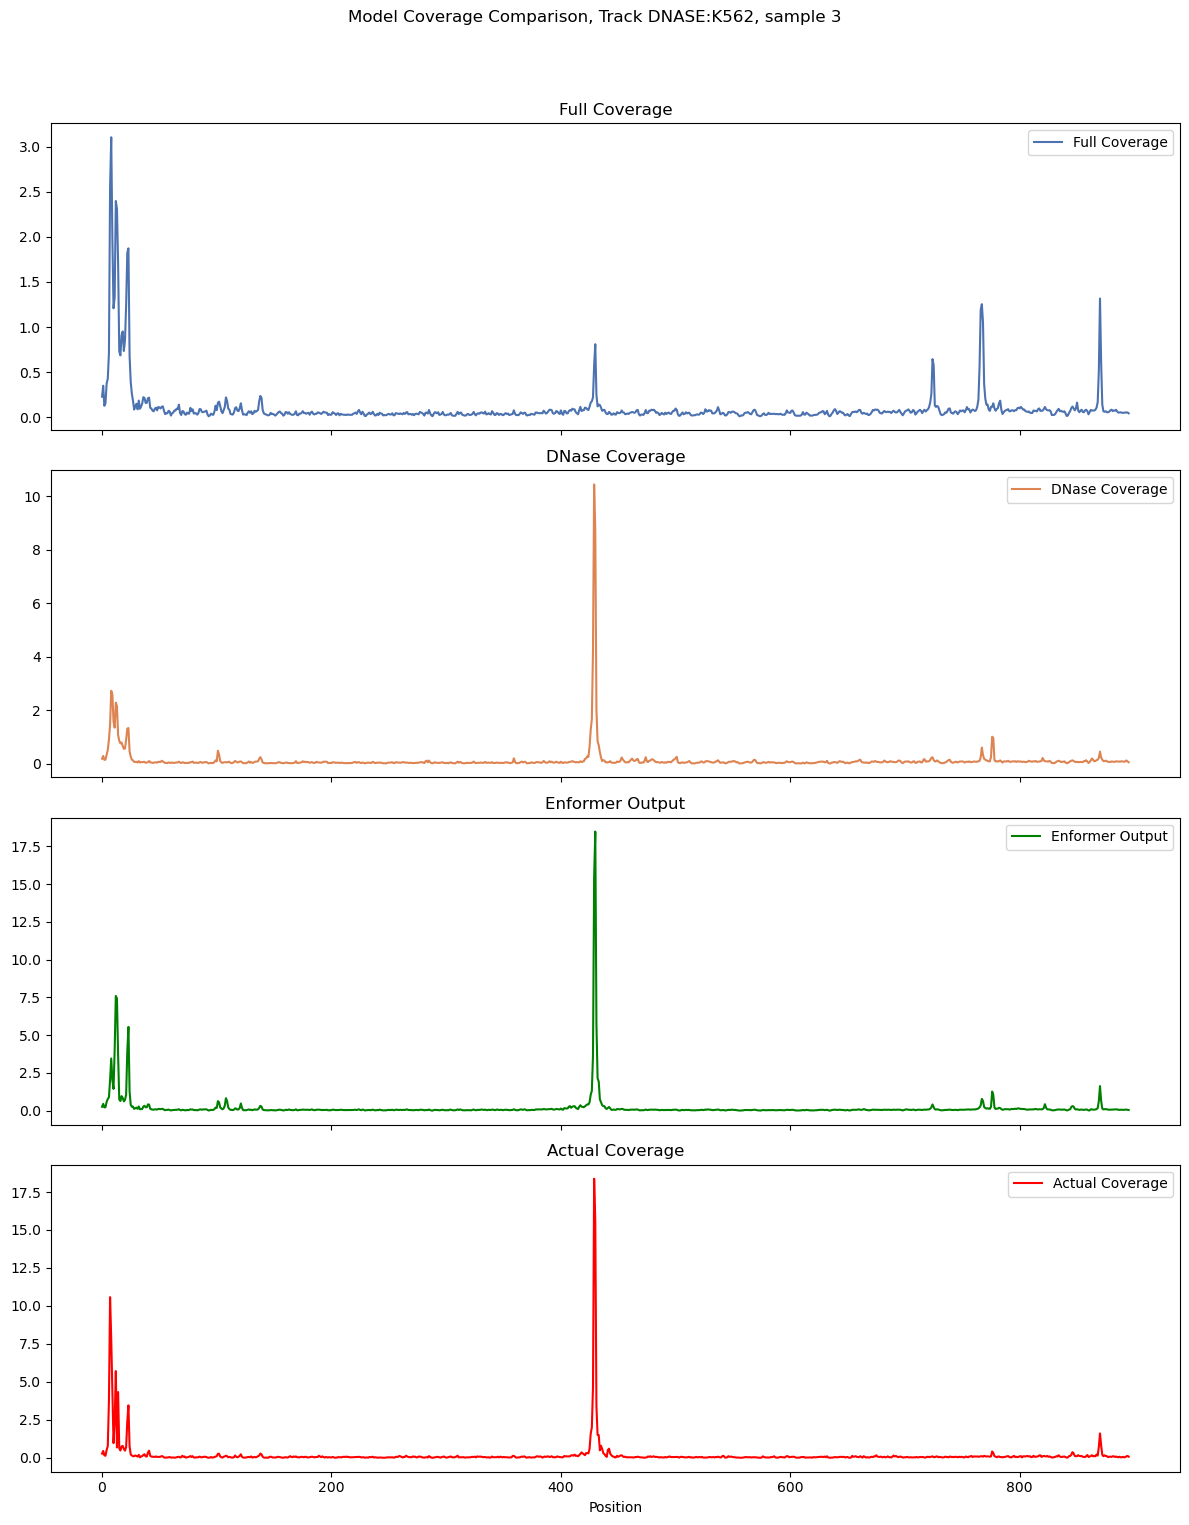

(<Figure size 1200x1600 with 4 Axes>,
 array([<Axes: title={'center': 'Full Coverage'}>,
        <Axes: title={'center': 'DNase Coverage'}>,
        <Axes: title={'center': 'Enformer Output'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [23]:
plot_track((evals, evals_dnase), enformer, 3, track=121, eval_names=['Full', 'DNase'])

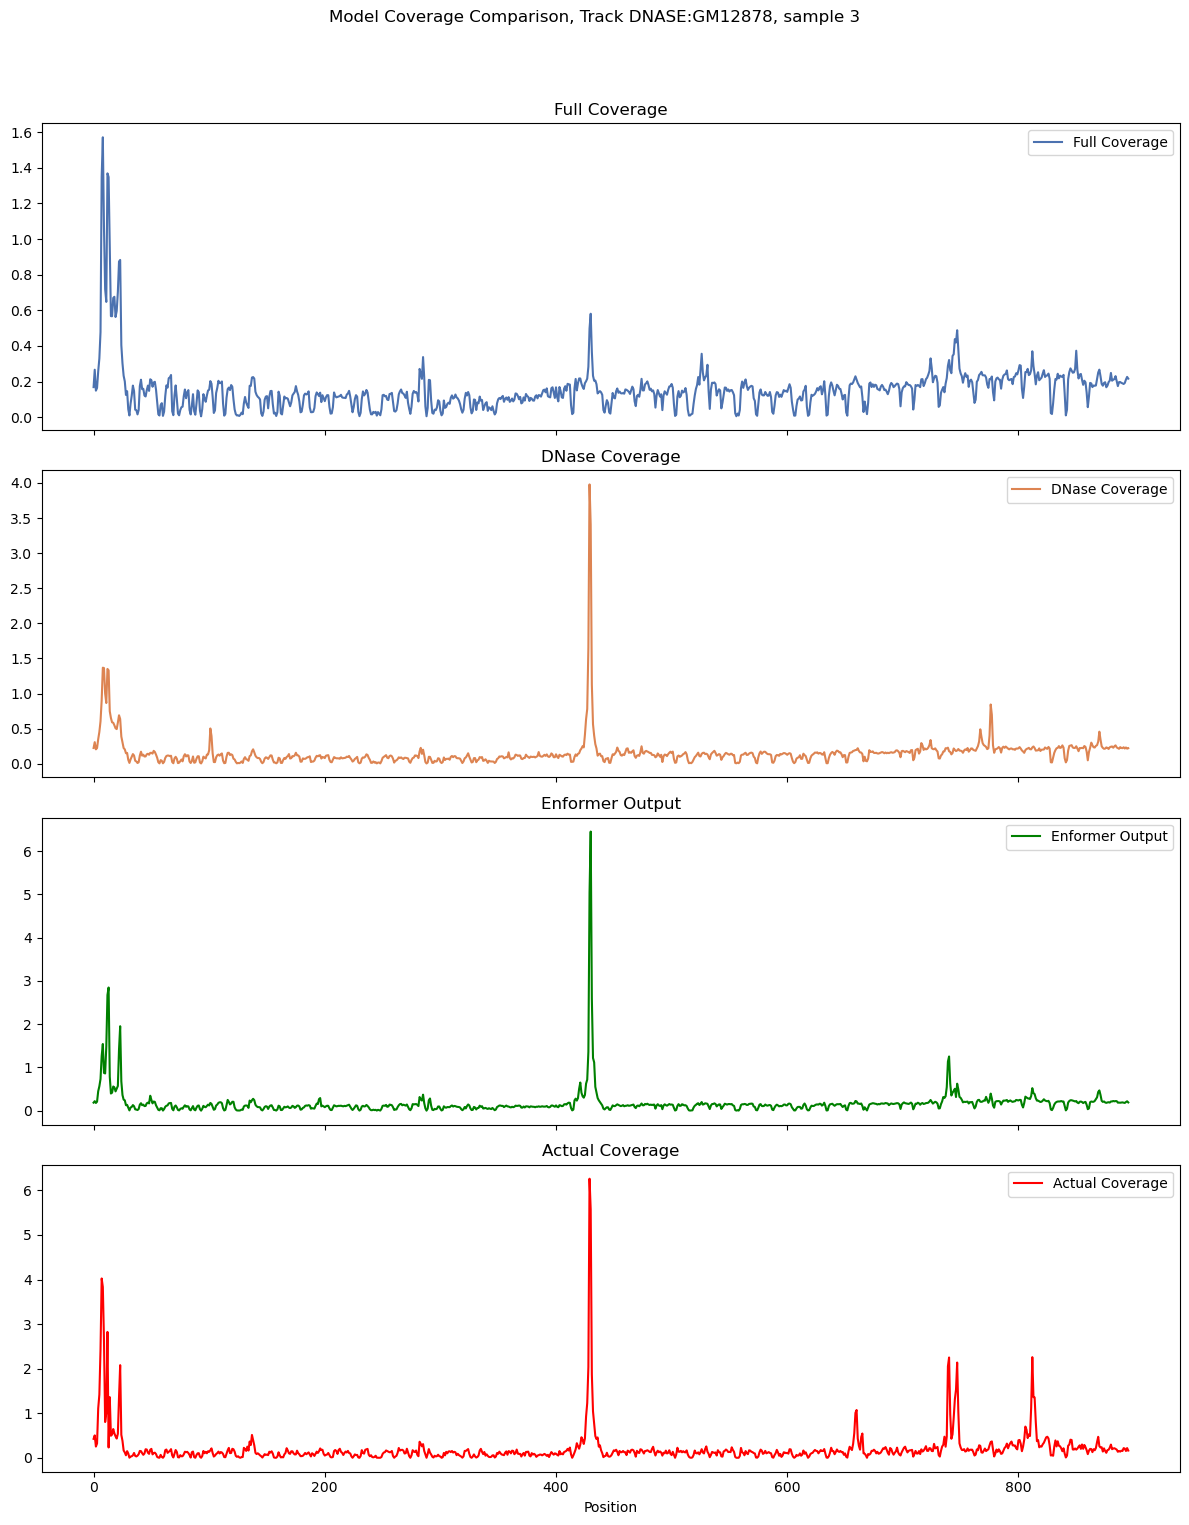

(<Figure size 1200x1600 with 4 Axes>,
 array([<Axes: title={'center': 'Full Coverage'}>,
        <Axes: title={'center': 'DNase Coverage'}>,
        <Axes: title={'center': 'Enformer Output'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [24]:
plot_track((evals, evals_dnase), enformer, 3, track=12, eval_names=['Full', 'DNase'])

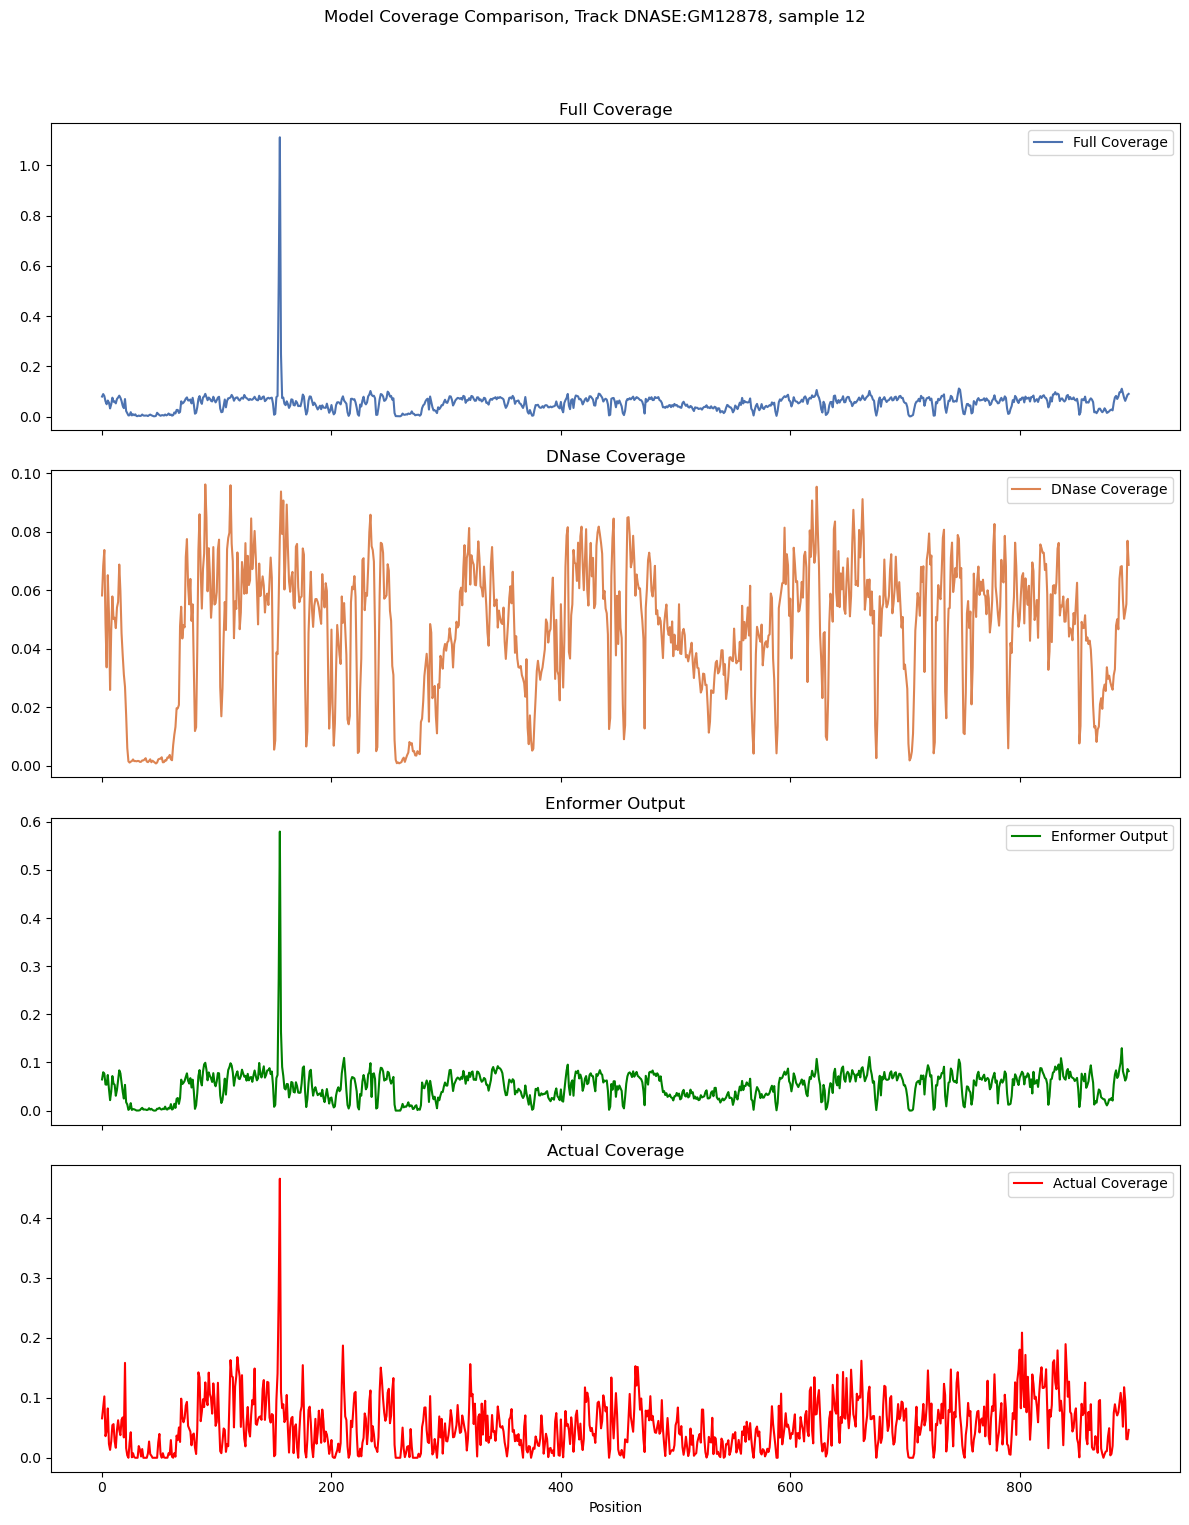

(<Figure size 1200x1600 with 4 Axes>,
 array([<Axes: title={'center': 'Full Coverage'}>,
        <Axes: title={'center': 'DNase Coverage'}>,
        <Axes: title={'center': 'Enformer Output'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [25]:
plot_track((evals, evals_dnase), enformer, 12, track=12, eval_names=['Full', 'DNase'])

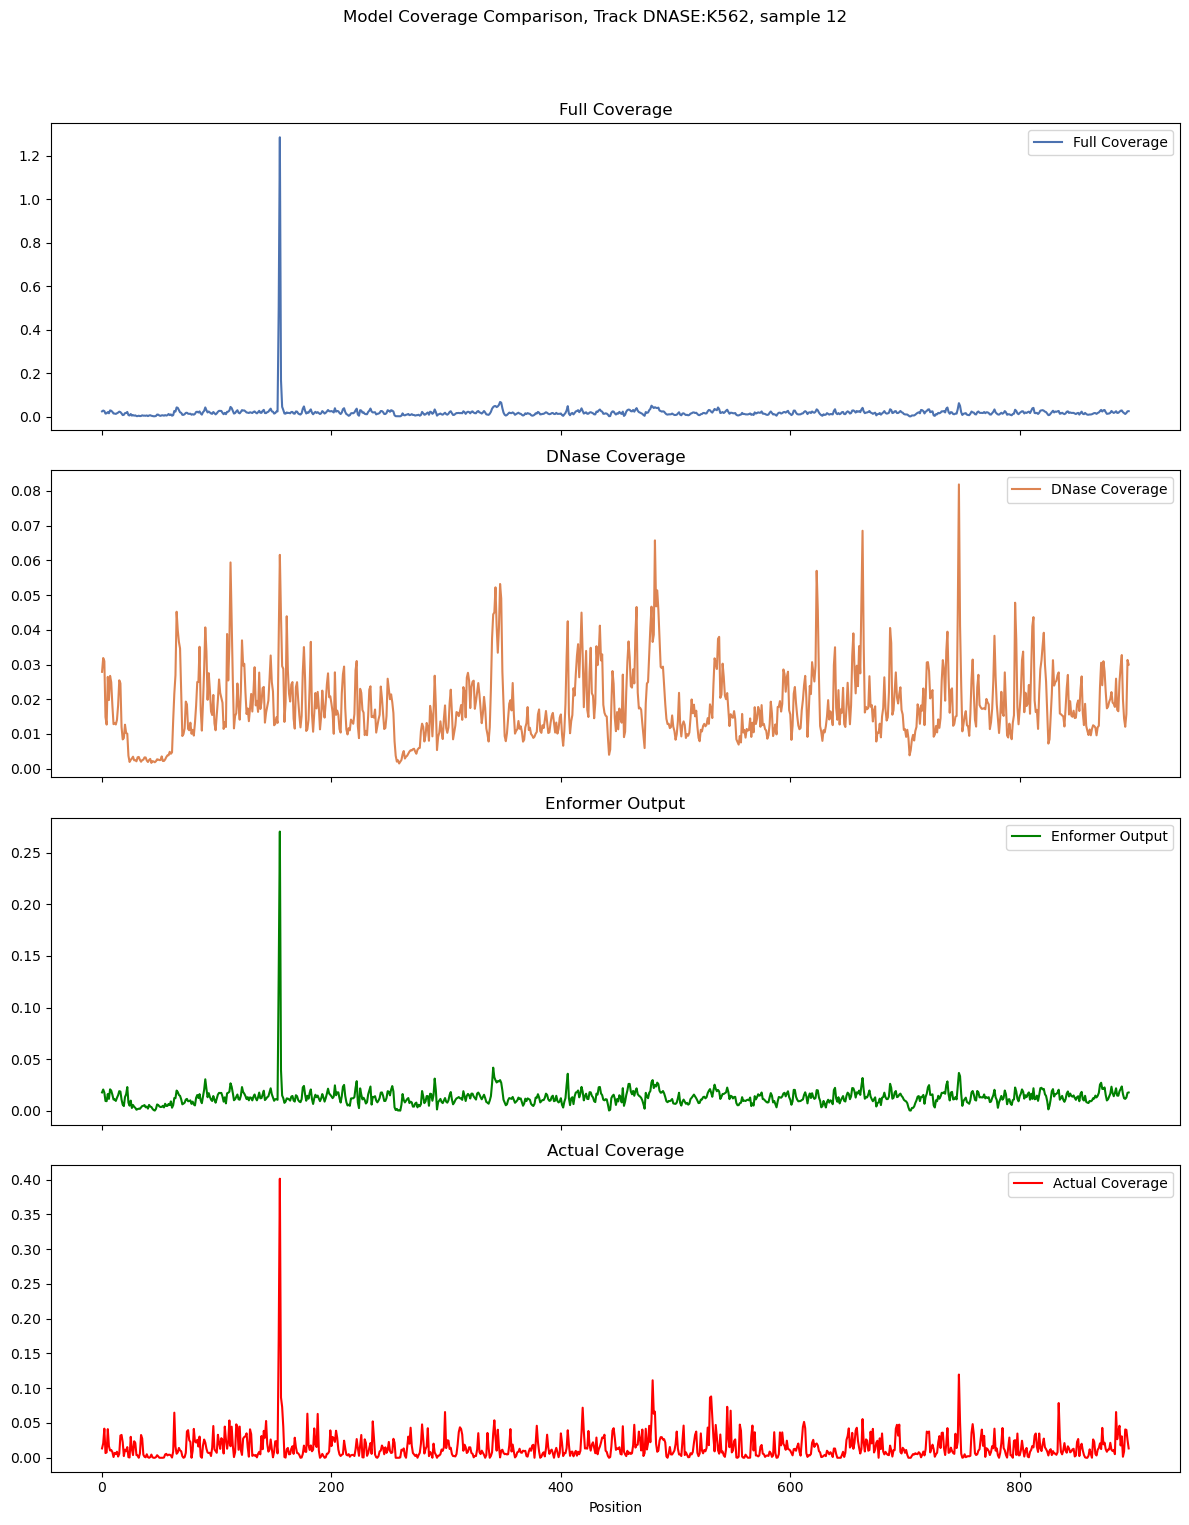

(<Figure size 1200x1600 with 4 Axes>,
 array([<Axes: title={'center': 'Full Coverage'}>,
        <Axes: title={'center': 'DNase Coverage'}>,
        <Axes: title={'center': 'Enformer Output'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [26]:
plot_track((evals, evals_dnase), enformer, 12, track=121, eval_names=['Full', 'DNase'])

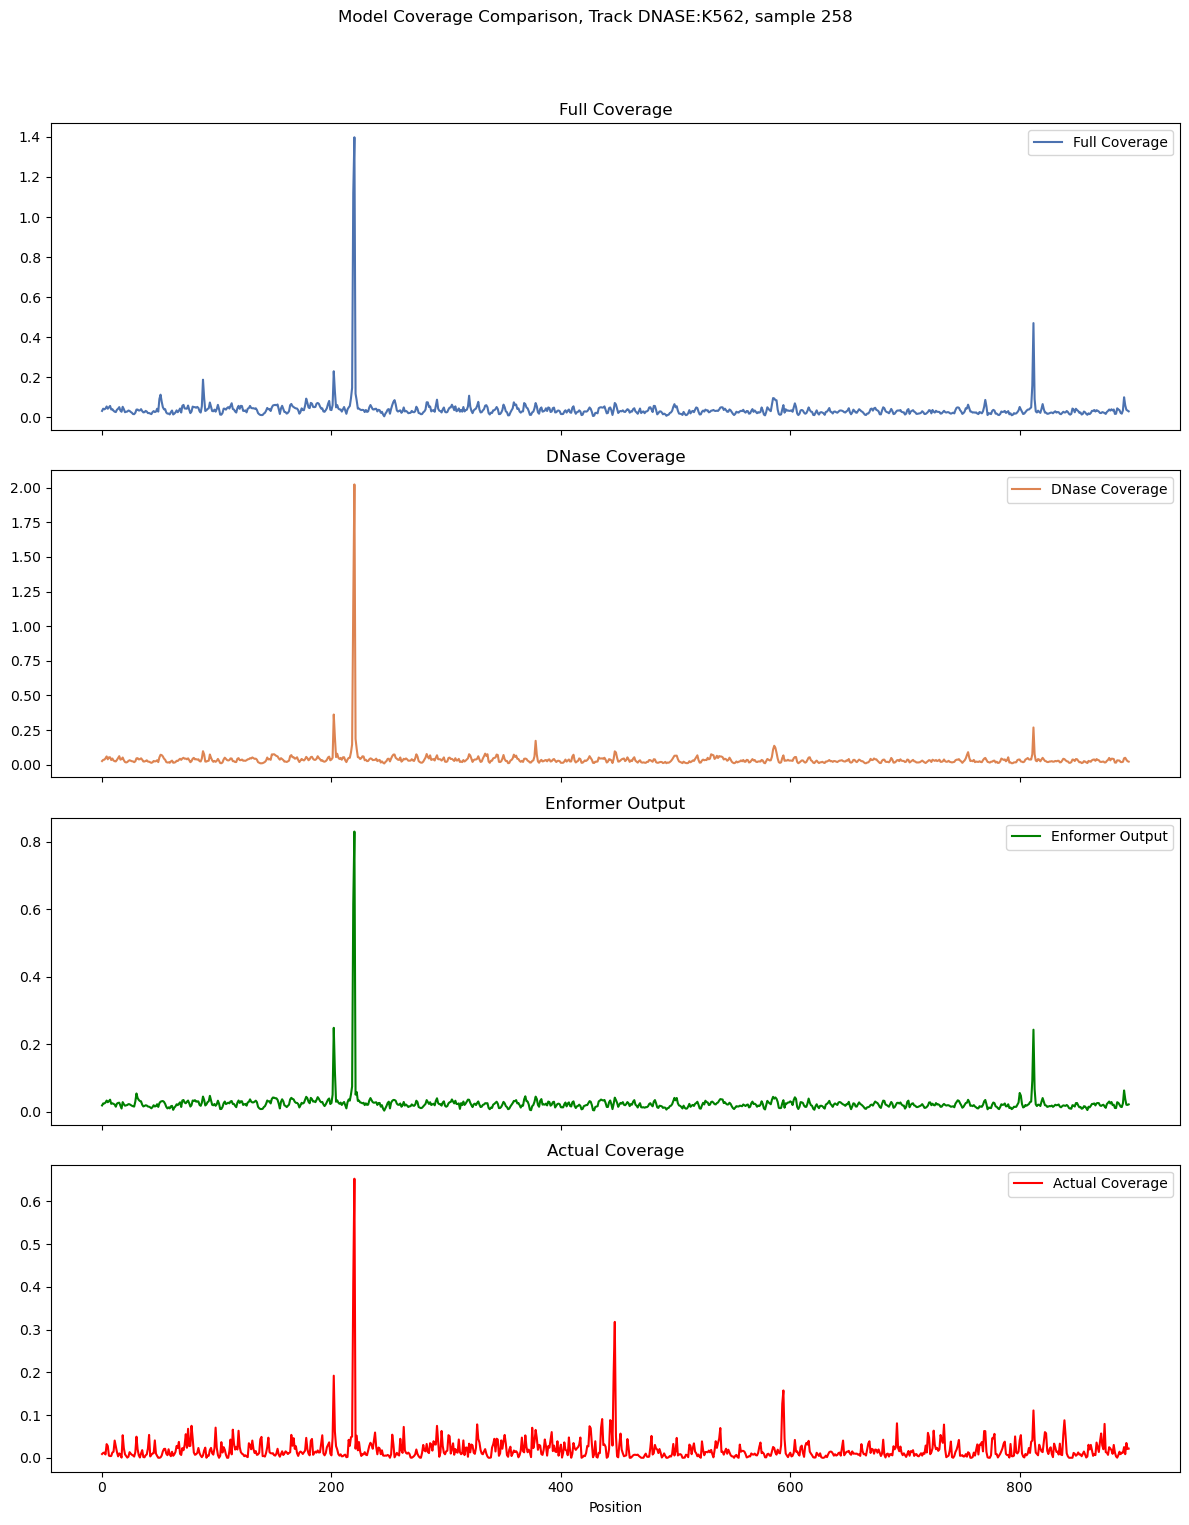

(<Figure size 1200x1600 with 4 Axes>,
 array([<Axes: title={'center': 'Full Coverage'}>,
        <Axes: title={'center': 'DNase Coverage'}>,
        <Axes: title={'center': 'Enformer Output'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [27]:
plot_track((evals, evals_dnase), enformer, 258, track=121, eval_names=['Full', 'DNase'])

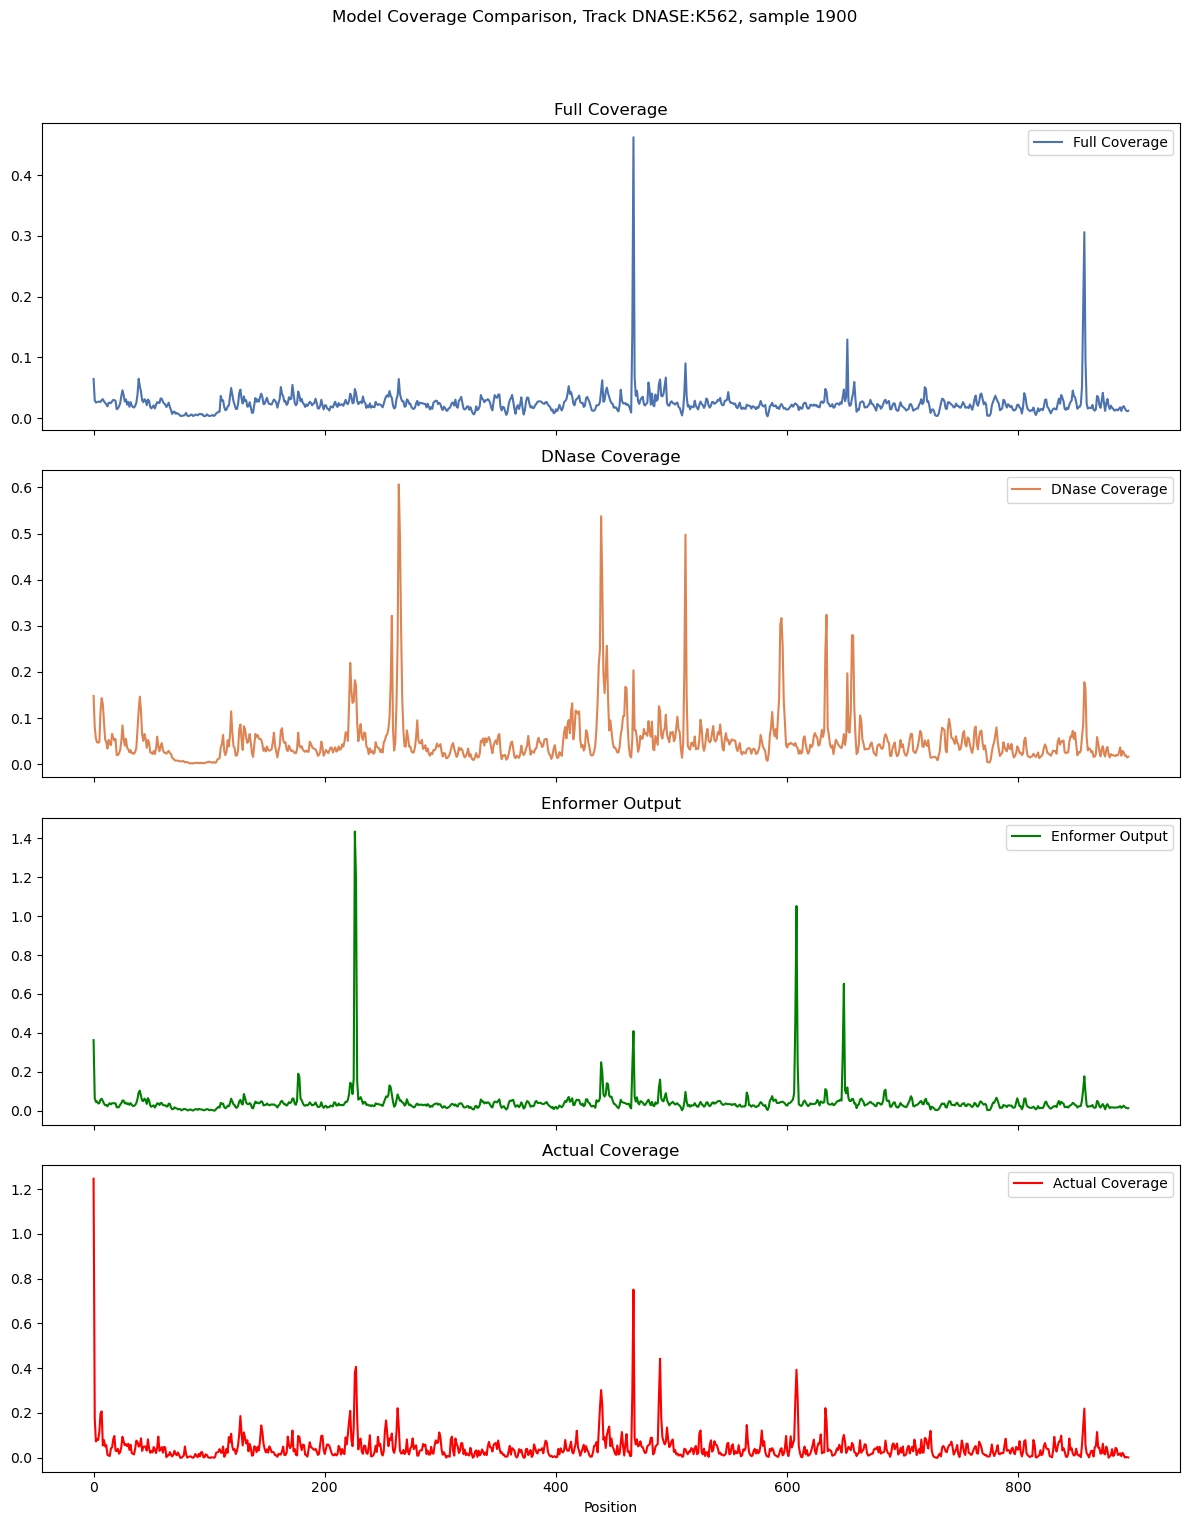

(<Figure size 1200x1600 with 4 Axes>,
 array([<Axes: title={'center': 'Full Coverage'}>,
        <Axes: title={'center': 'DNase Coverage'}>,
        <Axes: title={'center': 'Enformer Output'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [30]:
plot_track((evals, evals_dnase), enformer, 1900, track=121, eval_names=['Full', 'DNase'])

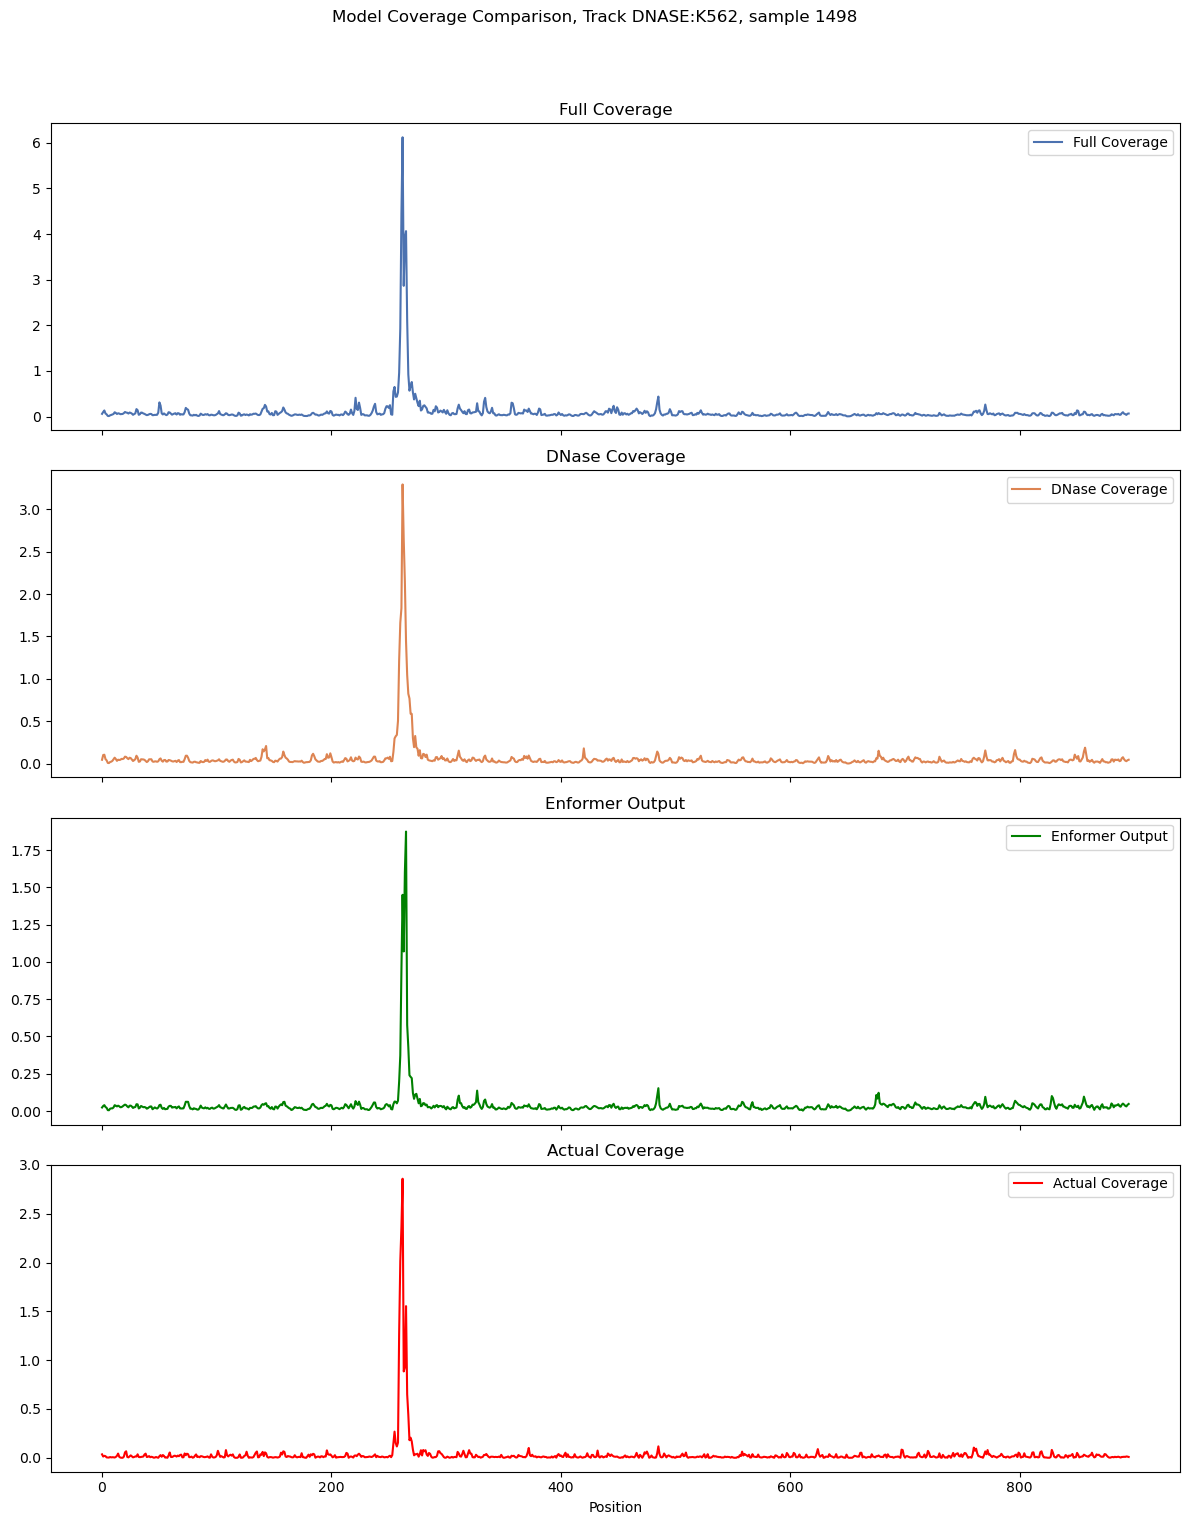

(<Figure size 1200x1600 with 4 Axes>,
 array([<Axes: title={'center': 'Full Coverage'}>,
        <Axes: title={'center': 'DNase Coverage'}>,
        <Axes: title={'center': 'Enformer Output'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [33]:
plot_track((evals, evals_dnase), enformer, 1498, track=121, eval_names=['Full', 'DNase'])

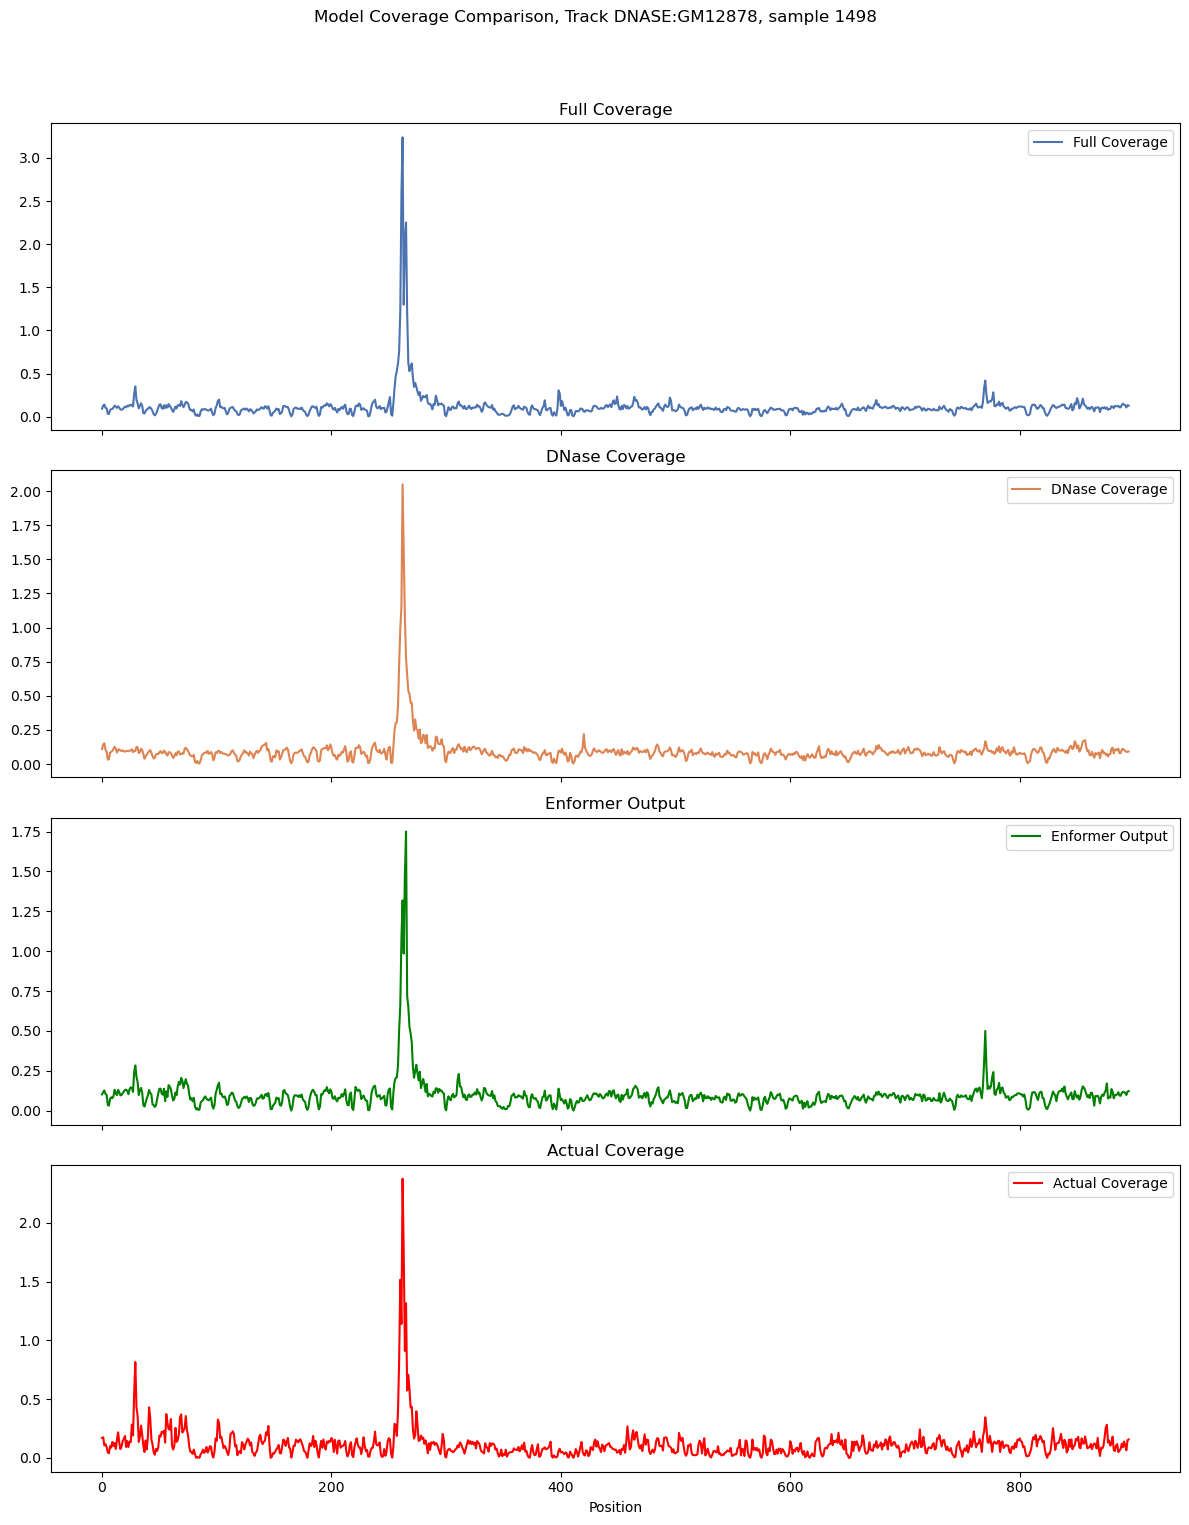

(<Figure size 1200x1600 with 4 Axes>,
 array([<Axes: title={'center': 'Full Coverage'}>,
        <Axes: title={'center': 'DNase Coverage'}>,
        <Axes: title={'center': 'Enformer Output'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [34]:
plot_track((evals, evals_dnase), enformer, 1498, track=12, eval_names=['Full', 'DNase'])

# cage model again

In [38]:
ckpt_path = '/data/leslie/sarthak/caduceus/outputs/2024-09-24/12-56-04-066829/checkpoints/30-val_loss=0.51606.ckpt'
evals_cage = e.Evals(ckpt_path)

Using kmer genome with length 6
5313


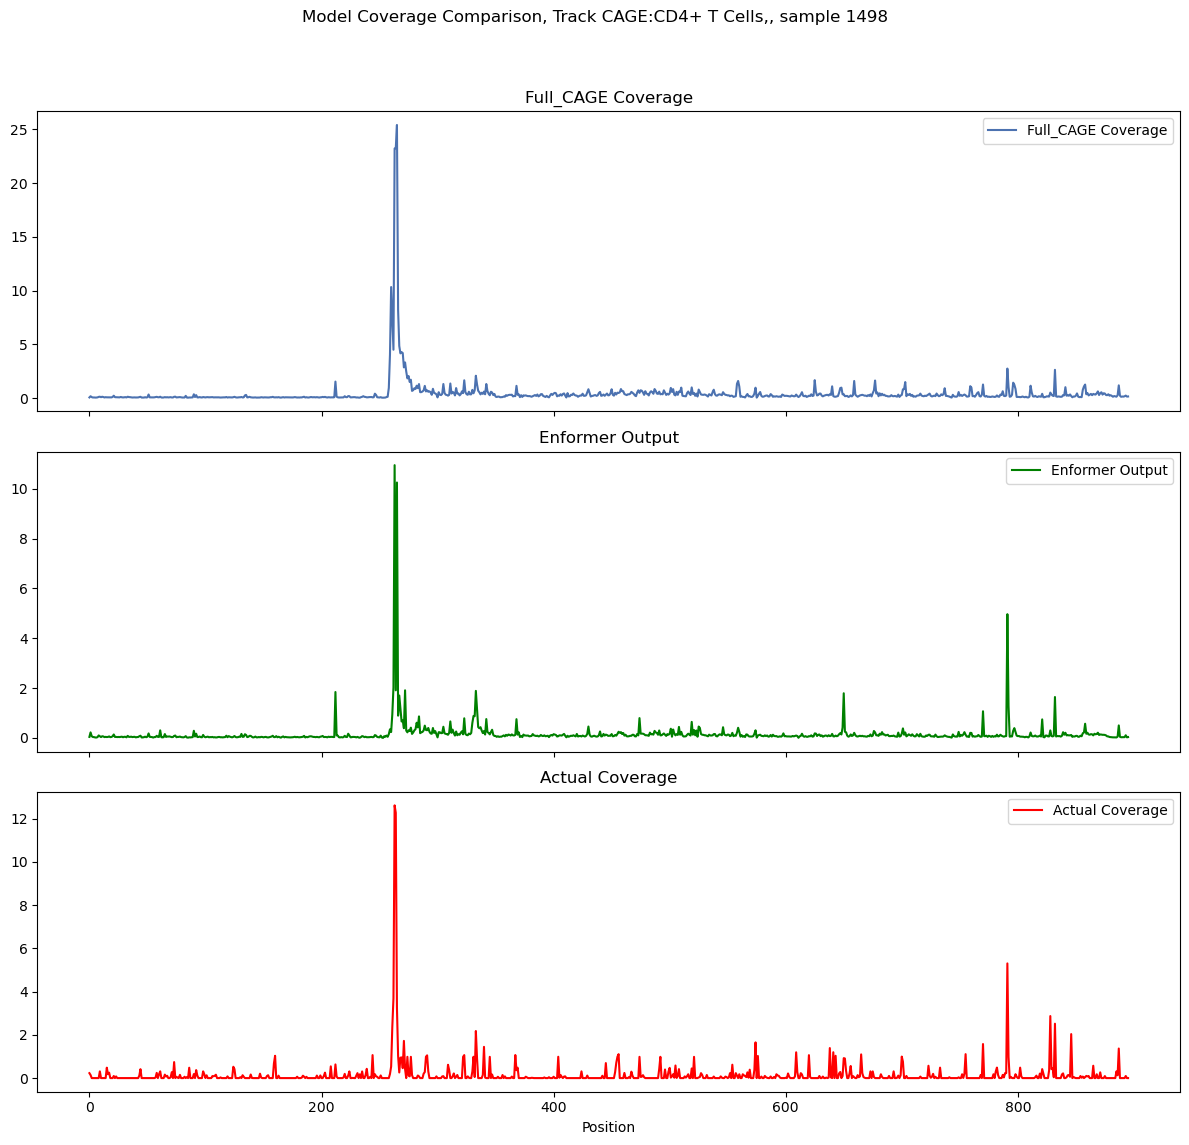

(<Figure size 1200x1200 with 3 Axes>,
 array([<Axes: title={'center': 'Full_CAGE Coverage'}>,
        <Axes: title={'center': 'Enformer Output'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [39]:
plot_track((evals_cage,), enformer, 1498, track=4759, eval_names=['Full_CAGE'])

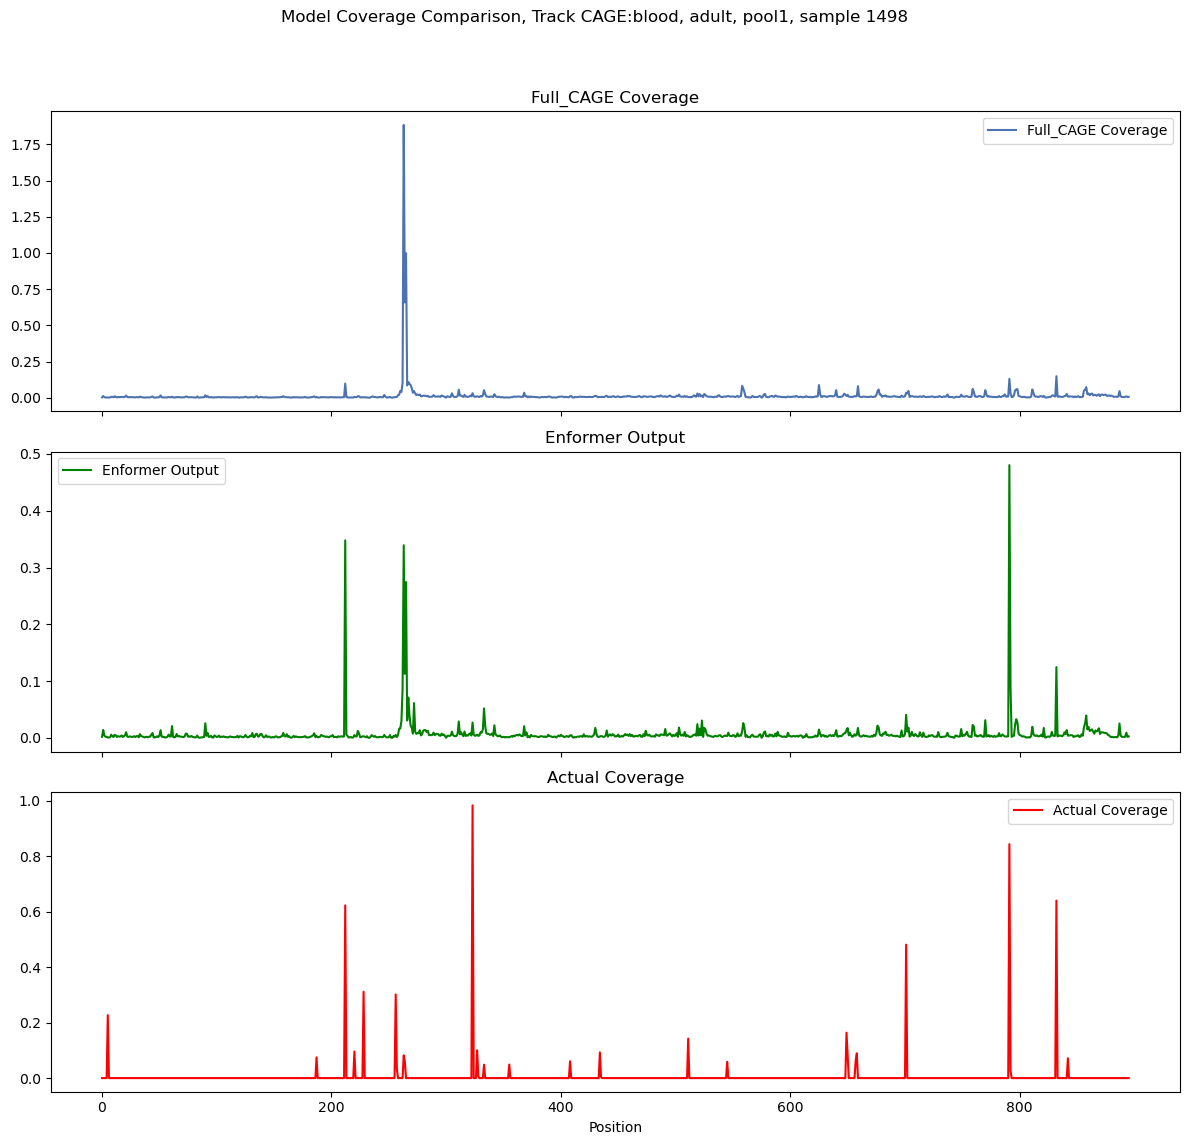

(<Figure size 1200x1200 with 3 Axes>,
 array([<Axes: title={'center': 'Full_CAGE Coverage'}>,
        <Axes: title={'center': 'Enformer Output'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [40]:
plot_track((evals_cage,), enformer, 1498, track=4950, eval_names=['Full_CAGE'])

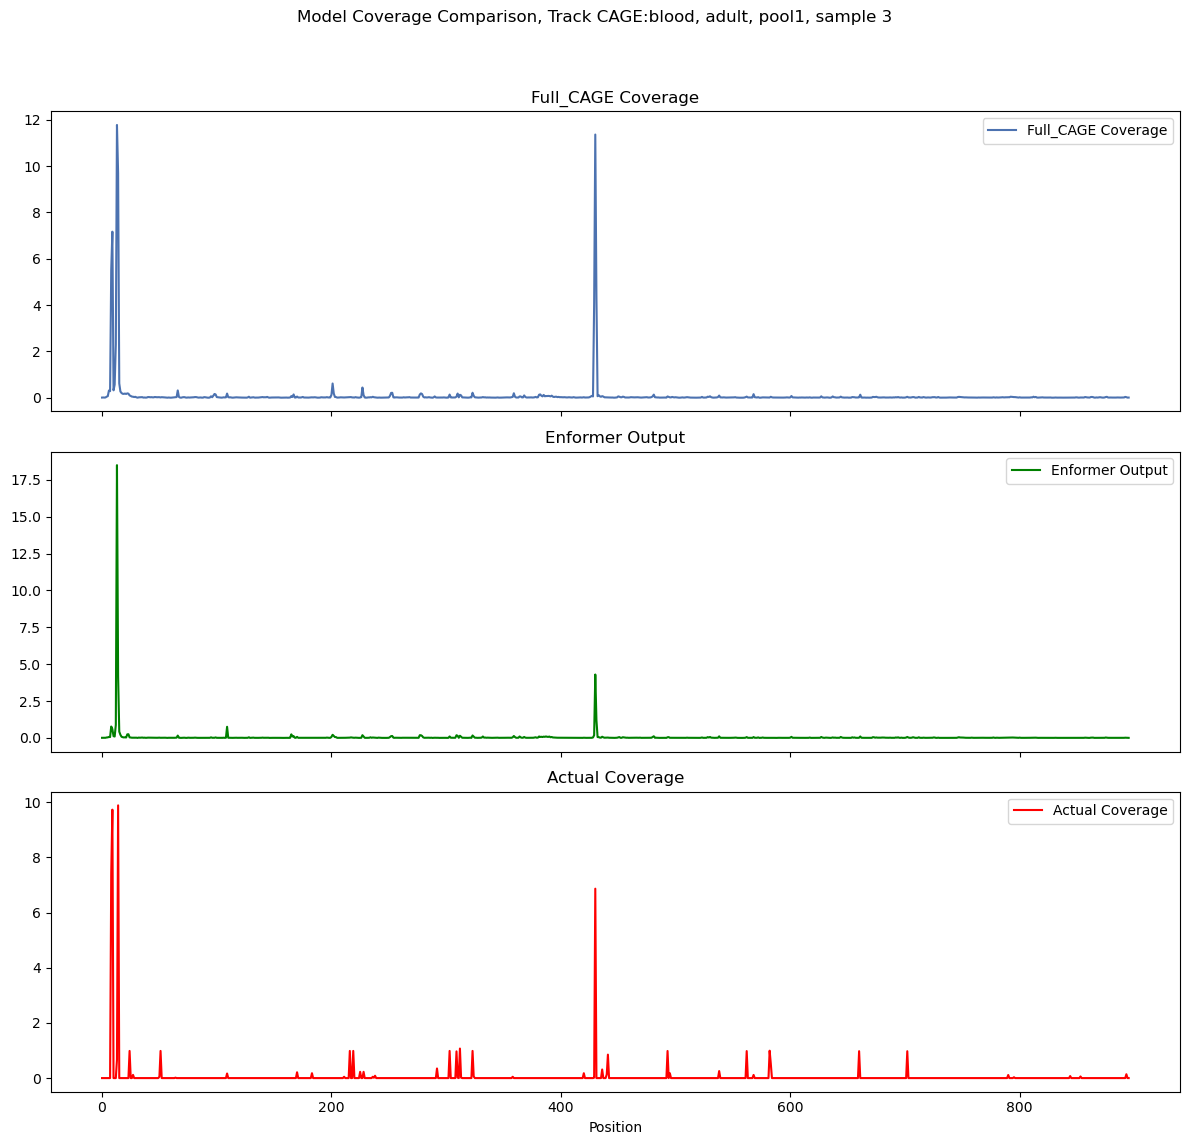

(<Figure size 1200x1200 with 3 Axes>,
 array([<Axes: title={'center': 'Full_CAGE Coverage'}>,
        <Axes: title={'center': 'Enformer Output'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [41]:
plot_track((evals_cage,), enformer, 3, track=4950, eval_names=['Full_CAGE'])

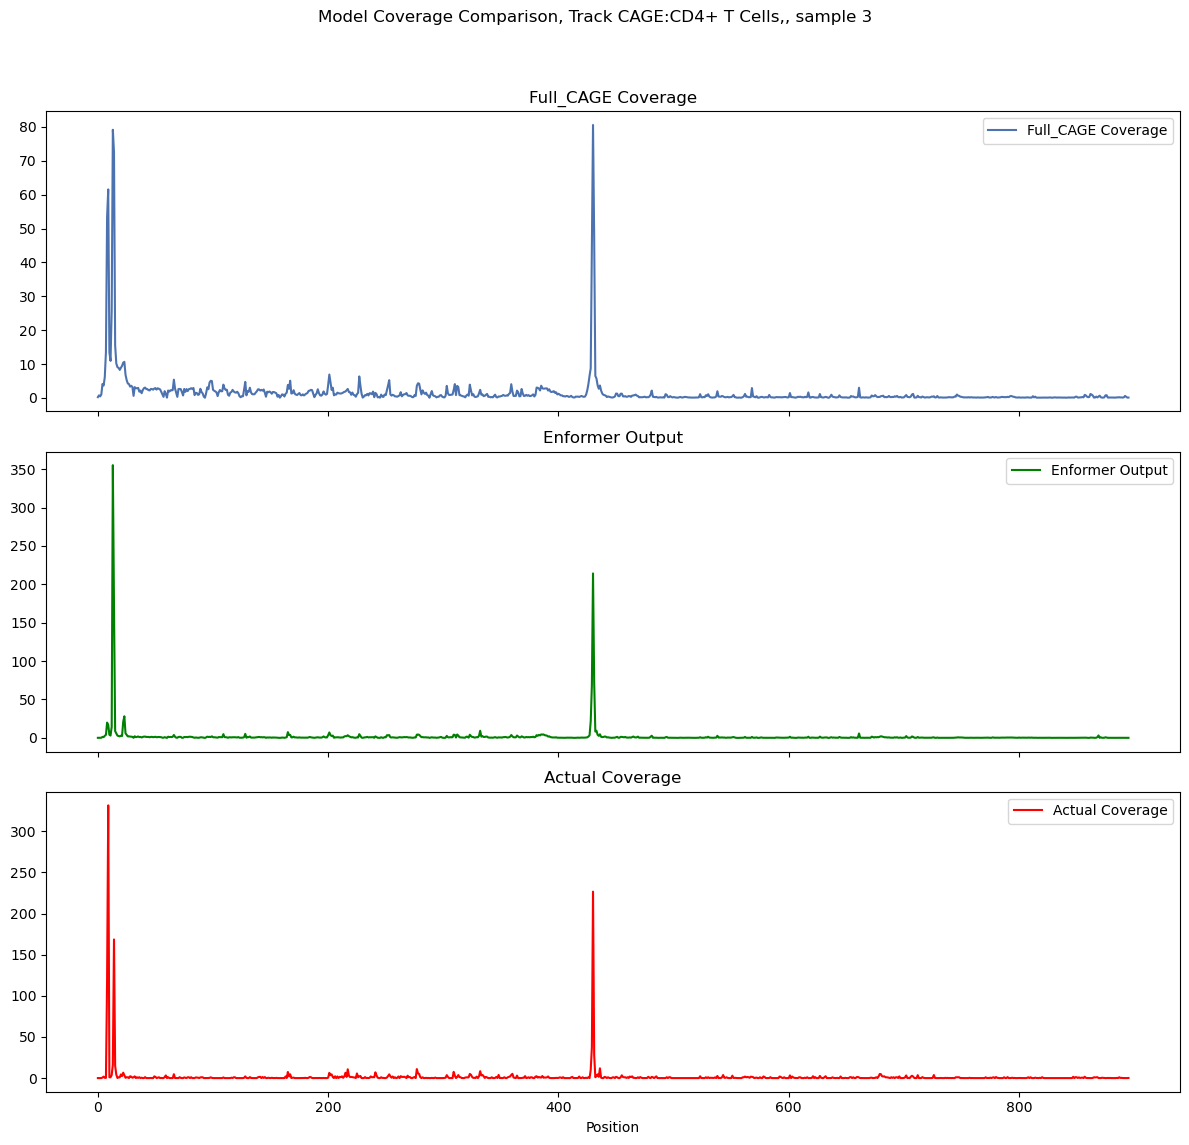

(<Figure size 1200x1200 with 3 Axes>,
 array([<Axes: title={'center': 'Full_CAGE Coverage'}>,
        <Axes: title={'center': 'Enformer Output'}>,
        <Axes: title={'center': 'Actual Coverage'}, xlabel='Position'>],
       dtype=object))

In [42]:
plot_track((evals_cage,), enformer, 3, track=4759, eval_names=['Full_CAGE'])

# compare DNase

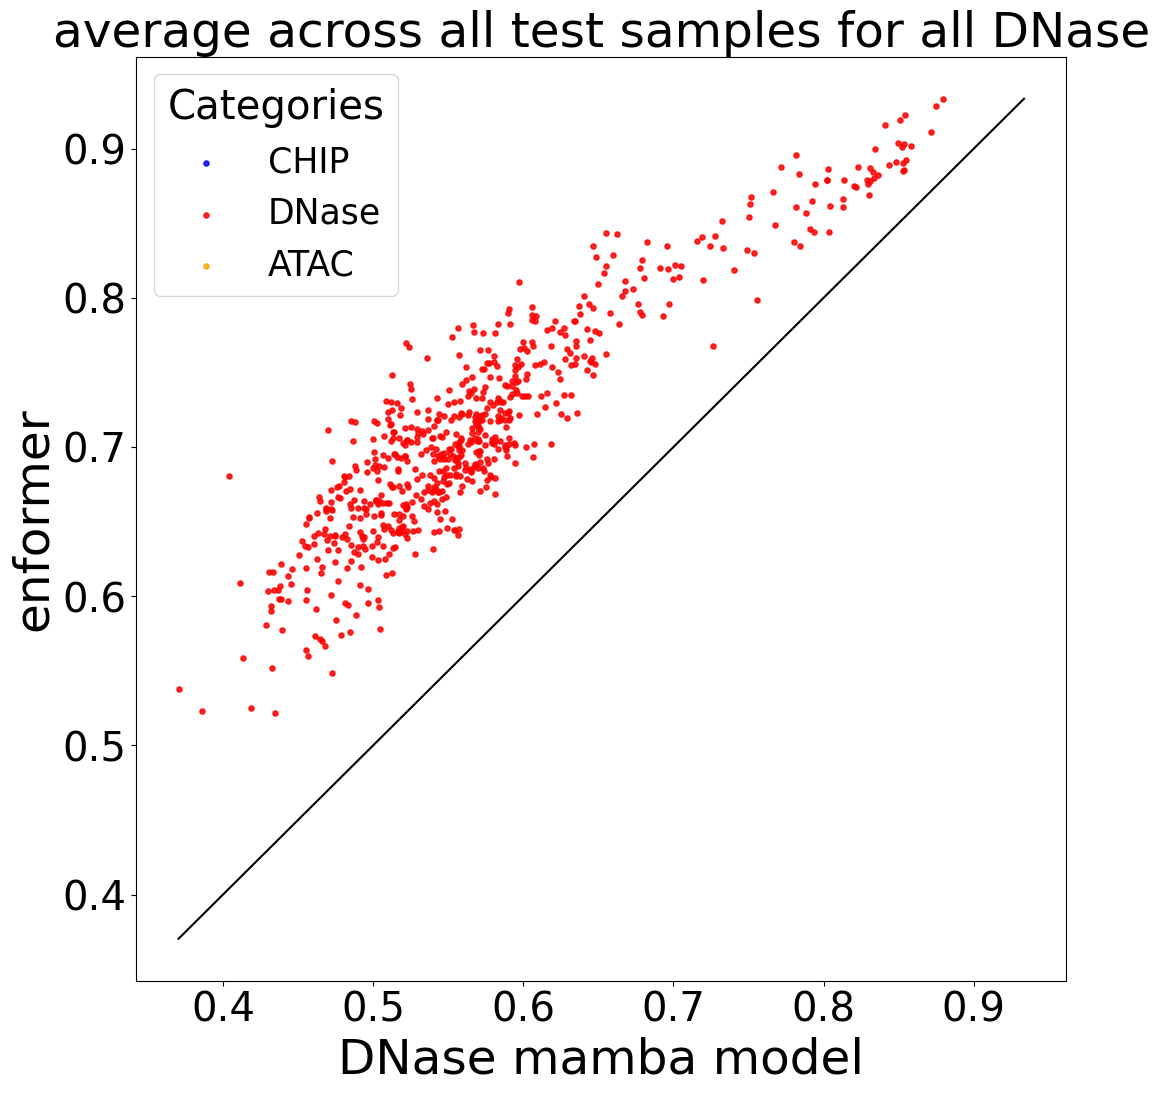

In [6]:
# see how this is compared to enformer
import numpy as np
import matplotlib.pyplot as plt

def fixcorrs(corr):
    corr[np.isnan(corr)] = 0
    corr[corr == -np.inf] = 0
    return corr

corr_kmer_new = np.load('/data/leslie/sarthak/data/enformer/data/model_out/enformer_kmer_mamba_DNase_1_epoch35.npy_corrs.npy')
corr_enformer = np.load('/data/leslie/sarthak/data/enformer/data/model_out/enformer.npy_corrsfull.npy')
y,x = fixcorrs(corr_enformer).mean(0)[:674], fixcorrs(corr_kmer_new).mean(0)[:674]

z2 = np.zeros_like(x)
z2[:675] = 1  # DNase (Category 0)
z2[675:685] = 2  # ATAC (Category 1)
z2[685:4675] = 0  # CHIP (Category 2)
# z2[4675:] = 1  # CAGE (Category 3)

# Define the colors for each category
colors = ['blue', 'red', 'orange']

# Create a color array based on z2
color_labels = np.array([colors[int(label)] for label in z2])

# Create a scatter plot with different colors for each category
plt.figure(1, figsize=(12, 12)).clf()

for i, color in enumerate(colors):
    plt.scatter(x[z2 == i], y[z2 == i], color=color, label=['CHIP', 'DNase', 'ATAC'][i], s=55, marker='.', alpha=0.85)

tempmin = np.min([np.min(x), np.min(y)])
tempmax = np.max([np.max(x), np.max(y)])

# plt.figure(1,figsize=(12,12)).clf()
# s = plt.scatter(x, y, c=z2, cmap='jet', marker='.', s = 85)
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  

plt.xlabel('DNase mamba model', fontsize=35)
plt.ylabel('enformer', fontsize=35)
plt.title('average across all test samples for all DNase', fontsize=35)
plt.tick_params(labelsize=29)
plt.legend(title="Categories", fontsize=25, title_fontsize=29)

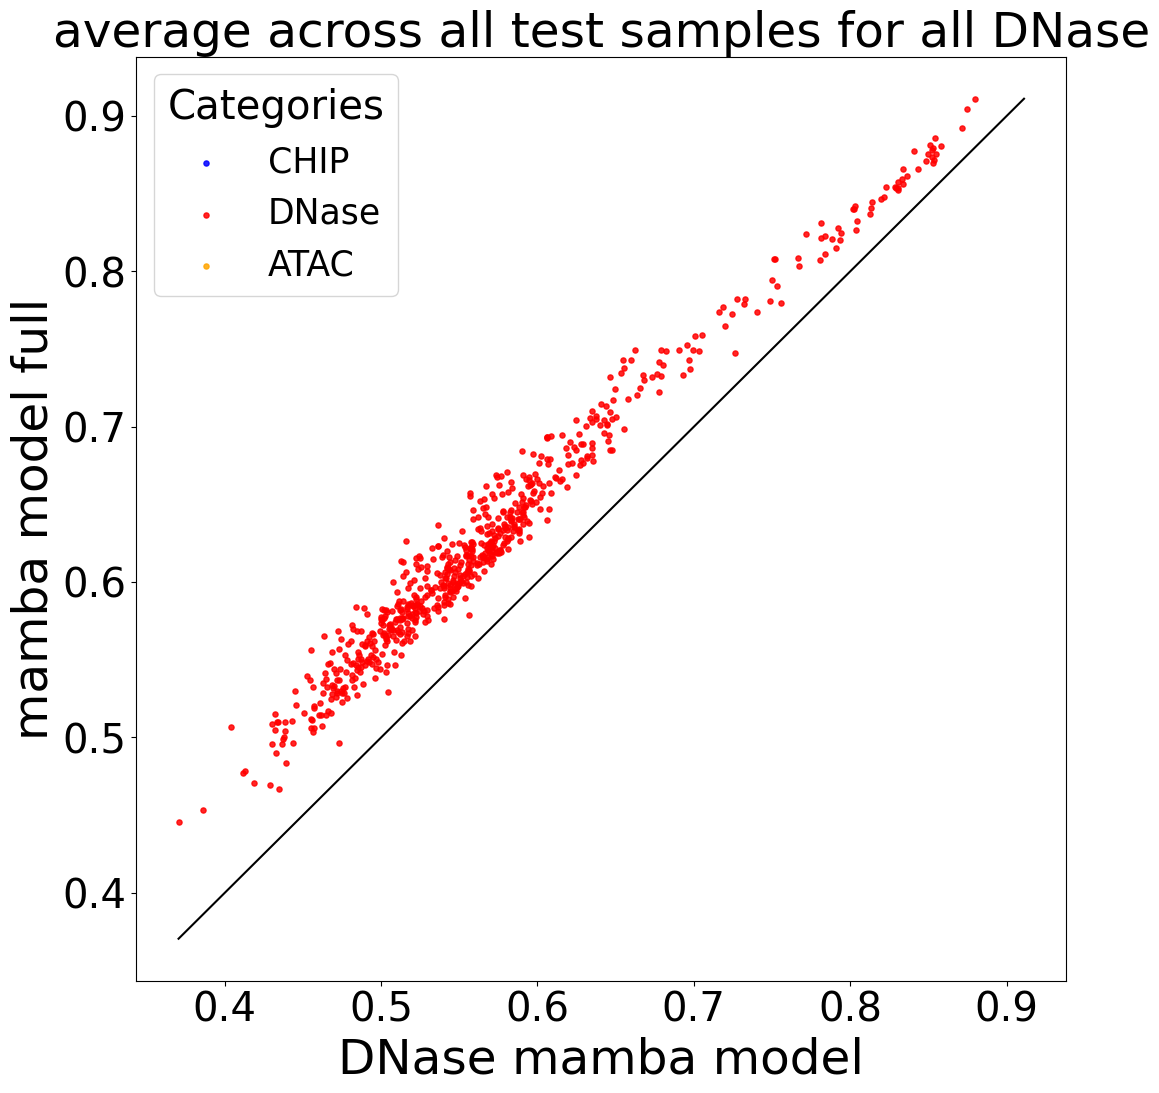

In [7]:
corr_kmer_new = np.load('/data/leslie/sarthak/data/enformer/data/model_out/enformer_kmer_mamba_DNase_1_epoch35.npy_corrs.npy')
corr_enformer = np.load('/data/leslie/sarthak/data/enformer/data/model_out/enformer_kmer_mamba_gradbatches_1_epoch35.npy_corrs.npy')
y,x = fixcorrs(corr_enformer).mean(0)[:674], fixcorrs(corr_kmer_new).mean(0)[:674]

z2 = np.zeros_like(x)
z2[:675] = 1  # DNase (Category 0)
z2[675:685] = 2  # ATAC (Category 1)
z2[685:4675] = 0  # CHIP (Category 2)
# z2[4675:] = 1  # CAGE (Category 3)

# Define the colors for each category
colors = ['blue', 'red', 'orange']

# Create a color array based on z2
color_labels = np.array([colors[int(label)] for label in z2])

# Create a scatter plot with different colors for each category
plt.figure(1, figsize=(12, 12)).clf()

for i, color in enumerate(colors):
    plt.scatter(x[z2 == i], y[z2 == i], color=color, label=['CHIP', 'DNase', 'ATAC'][i], s=55, marker='.', alpha=0.85)

tempmin = np.min([np.min(x), np.min(y)])
tempmax = np.max([np.max(x), np.max(y)])

# plt.figure(1,figsize=(12,12)).clf()
# s = plt.scatter(x, y, c=z2, cmap='jet', marker='.', s = 85)
plt.plot([tempmin, tempmax], [tempmin, tempmax], c='k')  

plt.xlabel('DNase mamba model', fontsize=35)
plt.ylabel('mamba model full', fontsize=35)
plt.title('average across all test samples for all DNase', fontsize=35)
plt.tick_params(labelsize=29)
plt.legend(title="Categories", fontsize=25, title_fontsize=29)